In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import random
# import pymc

In [2]:
from polyagamma import random_polyagamma


In [3]:
# Simulated Data
STUDENT_COUNT = 10
PROBLEM_COUNT = 50

a_star = np.random.uniform(0.5, 1.5, PROBLEM_COUNT)
b_star = np.linspace(-1, 1, PROBLEM_COUNT)
theta_star = np.random.normal(0, 1.25, STUDENT_COUNT)

Y = np.zeros((STUDENT_COUNT, PROBLEM_COUNT))
for p in range(len(Y)):
    for i in range(len(Y[p])):
        prob = np.exp(a_star[i] * theta_star[p] + b_star[i]) / (1 + np.exp(a_star[i] * theta_star[p] + b_star[i]))
        Y[p, i] = np.random.binomial(1, prob)



In [95]:
Y

array([[0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1.,
        0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 1.],
       [0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0.,
        1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1.,
        1., 1.],
       [1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0.,
        0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1.,
        1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
        1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
        1., 1.],
       [0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 

# Useful Functions

In [12]:
def sample_couple(prev_x, prev_y, tuning):
    log_p = lambda z: scipy.stats.multivariate_normal.logpdf(z, prev_x, tuning * np.ones(len(prev_x)))
    log_q = lambda z: scipy.stats.multivariate_normal.logpdf(z, prev_y, tuning * np.ones(len(prev_y)))
    
    x_prop = np.array([scipy.stats.multivariate_normal.rvs(prev_x, tuning * np.ones(len(prev_x)))]).ravel()
    
    if np.log(random.uniform(0, 1)) <= log_q(x_prop) - log_p(x_prop):
        return x_prop, x_prop
    else:
        y_prop = np.array([scipy.stats.multivariate_normal.rvs(prev_y, tuning * np.ones(len(prev_y)))]).ravel()
        while np.log(random.uniform(0, 1)) <= log_p(y_prop) - log_q(y_prop):
            y_prop = np.array([scipy.stats.multivariate_normal.rvs(prev_y, tuning * np.ones(len(prev_y)))]).ravel()
            
        return x_prop, y_prop


In [13]:
def ar(prev, prop, crit, log_pdf):
    log_r = log_pdf(prop) - log_pdf(prev)
    if crit <= log_r:
        return prop, 1
    else:
        return prev, 0

In [14]:
def equality(px, py):
    if all (px == py):
        return True
    else:
        return False

$$Y_{pi} | a, b, \theta \overset{ind.}{\sim} Ber(\frac{e^{a_i\theta_p + b_i}}{1 + e^{a_i\theta_p + b_i}}) \text{,  } 1 \leq i \leq I \text{,  } 1 \leq p \leq P$$

$$a_i | \sim N(0, \sigma_a^2)$$

$$b_i | \sim N(0, \sigma_b^2)$$

$$\sigma_a^2 = \sigma_b^2 = 100$$

$$\theta_i \sim N(0, 1)$$


$$p(Y_{pi} = 1| a, b, \theta) = \frac{e^{a_i\theta_p + b_i}}{1 + e^{a_i\theta_p + b_i}}$$

$$p(y | a, b, \theta) = \prod_i\prod_p (\frac{e^{a_i\theta_p + b_i}}{1 + e^{a_i\theta_p + b_i}})^{y_{pi}}(\frac{1}{1 + e^{a_i\theta_p + b_i}})^{1 - y_{pi}}$$

$$p(a, b, \theta) = p(y | a, b, \theta) \cdot p(a) \cdot p(b) \cdot p(\theta) = $$

$$\prod_i\prod_p (\frac{e^{a_i\theta_p + b_i}}{1 + e^{a_i\theta_p + b_i}})^{y_{pi}}(\frac{1}{1 + e^{a_i\theta_p + b_i}})^{1 - y_{pi}} \cdot \prod_i \frac{1}{\sqrt{200\pi}} \cdot e^{\frac{1}{200} \cdot a_i^2} \cdot \prod_i \frac{1}{\sqrt{200\pi}} \cdot e^{\frac{1}{200} \cdot b_i^2} \cdot \prod_p \frac{1}{\sqrt{2\pi}} \cdot e^{\frac{1}{2} \cdot \theta_i^2} \propto$$

$$\prod_i\prod_p (\frac{e^{a_i\theta_p + b_i}}{1 + e^{a_i\theta_p + b_i}})^{y_{pi}}(\frac{1}{1 + e^{a_i\theta_p + b_i}})^{1 - y_{pi}} \cdot \prod_i e^{\frac{1}{200} \cdot a_i^2} \cdot \prod_i \cdot e^{\frac{1}{200} \cdot b_i^2} \cdot \prod_p \cdot e^{\frac{1}{2} \cdot \theta_i^2} \propto$$

$$\ln p(a, b, \theta) = \sum_i\sum_p y_{pi} \cdot (a_i\theta_p + b_i) - \ln(1 + e^{a_i\theta_p + b_i}) + \sum_i \frac{1}{200} \cdot a_i^2 + \sum_i \frac{1}{200} \cdot b_i^2 + \sum_p \frac{1}{2} \cdot \theta_i^2$$

In [15]:
def logp_irt1(data, params):
    alphas = params[0: PROBLEM_COUNT]
    betas = params[PROBLEM_COUNT: (2 * PROBLEM_COUNT)]
    thetas = params[(2 * PROBLEM_COUNT):]

    total_sum = 0

    for p in range(len(data)):
        for i in range(len(data[p])):
            total_sum += data[p][i] * (alphas[i] * thetas[p] + betas[i]) - np.log(1 + np.exp(alphas[i] * thetas[p] + betas[i]))
    
    return total_sum - np.sum(np.power(alphas, 2)) / 200 - np.sum(np.power(betas, 2)) / 200 - np.sum(np.power(thetas, 2)) / 2

    

$$W_{pi} \sim PG(1, a_i\theta_p + b_i)$$

$$g_c(w) = cosh(c / 2) e^{-\frac{c^2w}{2}}g_0(w)$$

$$g_0(w) = \sum_{k = 0}^\infty (-1)^k \frac{(2k + 1)}{\sqrt{2\pi w^3}}e^{- \frac{(k + 1)^2}{8w}} \mathbb{1}_{(0, \infty)}(w)$$

$$cosh(x) = (e^x + e^{-x}) / 2$$

$$f(y, w | a, b, \theta) = \prod_i\prod_p \frac{e^{y_{pi}(a_i\theta_p + b_i)}(e^{\frac{a_i\theta_p + b_i}{2}} + e^{-\frac{a_i\theta_p + b_i}{2}})}{2(1 + e^{a_i\theta_p + b_i})}e^{-\frac{w_{pi}}{2}(a_i\theta_p + b_i)^2}g_0(w_{pi})$$

$$\pi(w, a, b, \theta | y) \propto p(a, b, \theta) \prod_i\prod_p exp((y_{pi} - \frac{1}{2})(a_i\theta_p + b_i) - \frac{w_{pi}}{2}(a_i\theta_p + b_i)^2)g_0(w_{pi})$$

$$a_i | w_{\cdot i}, b_i, \theta \sim N(v_i^2\sum_p\theta_p(y_{pi} - 0.5 - b_iw_{pi}), (\frac{1}{100} + \sum_p w_{pi}\theta_p^2)^{-1})$$

$$b_i | w_{\cdot i}, a_i, \theta \sim N(v_i^2\sum_p\theta_p(y_{pi} - 0.5 - a_iw_{pi}\theta_p), (\frac{1}{100} + \sum_p w_{pi}\theta_p^2)^{-1})$$

$$\theta_p | w_{p\cdot}, a, b \sim N((1 + \sum_i a_i^2w_{pi})^{-1} \sum_i (a_i(y_{pi} - 0.5) - a_ib_iw_{pi}), (1 + \sum_i a_i^2w_{pi})^{-1})$$


$$U_i = \sum_p (y_{pi} - 0.5)\theta_p$$

$$V_{ij} = \begin{cases} \frac{1}{100} + \sum_p W_{pi}\theta_p^2, & i = j\\
\sum_p\theta_pW_{pi}, & |j - i| = p\\
0, & else\end{cases}$$

$$(a, b) | w, \theta \sim MVN(V^{-1}U, V^{-1})$$

In [16]:
def polyagamma(data, params):
    temp = np.zeros(params[0].shape)
    for p in range(len(temp)):
        for i in range(len(temp[p])):
            temp[p][i] = random_polyagamma(z = params[1][i] * params[3][p] + params[2][i])
    return temp
    
def alpha(data, params):
    temp = np.zeros(len(params[1]))
    
    for i in range(PROBLEM_COUNT):
        v_squared = 1 / (1 / 100 + np.dot(params[0][:,i], np.power(params[3], 2)))
        m = v_squared * np.dot(params[3], data[0][:,i] - 0.5 - params[2][i] * params[0][:,i])
        temp[i] = np.random.normal(m, np.sqrt(v_squared))

    return temp

def beta(data, params):
    temp = np.zeros(len(params[2]))
    
    for i in range(PROBLEM_COUNT):
        v_squared = 1 / (1 / 100 + np.sum(params[0][:,i]))
        m = v_squared * np.sum(data[0][:,i] - 0.5 - params[1][i] * params[3] * params[0][:,i])
        temp[i] = np.random.normal(m, np.sqrt(v_squared))

    return temp
                                    

def theta(data, params):
    temp = np.zeros(len(params[3]))
    for p in range(STUDENT_COUNT):
        v_squared = 1 / (1 + np.dot(params[0][p], np.power(params[1], 2)))
        m = v_squared * np.dot(params[1], data[0][p] - 0.5 - params[2] * params[0][p])      
        temp[p] = np.random.normal(m, np.sqrt(v_squared))

    return temp



In [17]:
def gibbs_wrapper(data, x_init, y_init, max_iteration = 10000):
    params_x = [x_init]
    params_y = [y_init]

    for i in range(max_iteration):
        temp_x = params_x[-1].copy()
        temp_x[1] = alpha(data, temp_x)
        temp_x[2] = beta(data, temp_x)
        temp_x[3] = theta(data, temp_x)
        temp_x[0] = polyagamma(data, temp_x)
        params_x.append(temp_x)

        temp_y = params_y[-1].copy()
        temp_y[1] = alpha(data, temp_y)
        temp_y[2] = beta(data, temp_y)
        temp_y[3] = theta(data, temp_y)
        temp_y[0] = polyagamma(data, temp_y)
        params_y.append(temp_y)

    return params_x, params_y
        

In [17]:
def log_bb(data, params):
    if any(params <= 0) or any(params[2:] > 1):
        return -float("inf")
    else:
        return -len(data[0]) * np.log(scipy.special.beta(params[0], params[1])) + np.sum((data[0] + params[0] - 1) * np.log(params[2:])) + np.sum((data[1] - data[0] + params[1] - 1) * np.log(1 - params[2:]))
        

In [18]:
#def coupled_metropolis2(data, x_init, y_init, converge_fun, coupling_fun, logpdf_fun, tuning, k = 100, lag = 1, maximum_iteration = 10000):

def coupled_metropolis2(data, x_init, y_init, converge_fun, logpdf_fun, tuning, k = 100, lag = 1, maximum_iteration = 10000):

    params_x = [np.array(x_init)]
    params_y = [np.array(y_init)]
    
    iteration = 0
    
    while not converge_fun(params_x[-1], params_y[-1]):
        if lag <= iteration:
            x_prop, y_prop = sample_couple(params_x[-1], params_y[-1], tuning)
            #x_prop, y_prop = coupling_fun(params_x[-1], params_y[-1], tuning)

            for j in range(len(x_prop)):
                logu = np.log(random.uniform(0, 1))
                x_prop[j] = ar(params_x[-1][j], x_prop[j], logu, lambda z: logpdf_fun(data, np.hstack((params_x[-1][:j], z, params_x[-1][j + 1:]))))[0]
                y_prop[j] = ar(params_y[-1][j], y_prop[j], logu, lambda z: logpdf_fun(data, np.hstack((params_y[-1][:j], z, params_y[-1][j + 1:]))))[0]
            
            params_x.append(x_prop)
            params_y.append(y_prop)

        else:
            x_prop = scipy.stats.multivariate_normal.rvs(params_x[-1], tuning * np.ones(len(params_x[-1])))
            
            for j in range(len(x_prop)):
                logu = np.log(random.uniform(0, 1))
                x_prop[j] = ar(params_x[-1][j], x_prop[j], logu, lambda z: logpdf_fun(data, np.hstack((params_x[-1][:j], z, params_x[-1][j + 1:]))))[0]

            params_x.append(x_prop)
            
        iteration += 1
        if iteration == maximum_iteration:
            break
        
    print(iteration)

    if iteration != maximum_iteration:
        for i in range(k):
            x_prop = scipy.stats.multivariate_normal.rvs(params_x[-1], tuning * np.ones(len(params_x[-1])))
            for j in range(len(x_prop)):
                logu = np.log(random.uniform(0, 1))
                x_prop[j] = ar(params_x[-1][j], x_prop[j], logu, lambda z: logpdf_fun(data, np.hstack((params_x[-1][:j], z, params_x[-1][j + 1:]))))[0]
    
            params_x.append(x_prop)
            params_y.append(x_prop)
        
    return params_x, params_y, iteration
    

In [19]:
n = data1['n'].to_numpy()
y = data1['y'].to_numpy()
data = [y, n]

a_1 = 1
b_1 = 2
theta_1 = np.random.beta(y + a_1, n - y + b_1, 15)

a_2 = 20
b_2 = 50
theta_2 = np.random.beta(y + a_2, n - y + b_2, 15)

x_init = np.append([a_1, b_1], theta_1)
y_init = np.append([a_2, b_2], theta_2)

params_x, params_y, iteration = coupled_metropolis2(data, x_init, y_init, equality, log_bb, tuning = np.array([0.3, 1.1] + [0.01] * 15), k = 1000)

740


In [20]:
chain1_df = pd.DataFrame(params_x, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15'])
chain2_df = pd.DataFrame(params_y, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15'])
chain1_df = chain1_df.reset_index().rename(columns = {'index': 'iteration'})
chain2_df = chain2_df.reset_index().rename(columns = {'index': 'iteration'})

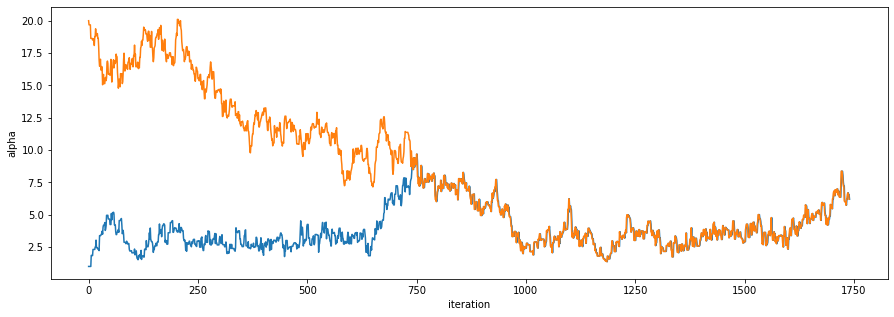

In [21]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

In [39]:
def coupled_metropolis_gibbs(data, x_init, y_init, converge_fun, logpdf_fun, tuning, gibbs_vec, k = 100, lag = 1):
    params_x = [x_init]
    params_y = [y_init]
    ss = np.power(x_init[-1], 2) + np.power(y_init[-1], 2)
    s = x_init[-1] + y_init[-1]

    accept = np.array([2] * len(x_init[-1]))
    total = 2
    iteration = 0
    
    tuning = np.maximum(ss / total - np.power(s / total, 2), 0.001) 
    c = (accept / total - 0.3)/total
    
    while not converge_fun(params_x[-1], params_y[-1]):
        if lag <= iteration:
            temp_x = np.zeros(len(x_init), dtype = 'object')
            temp_y = np.zeros(len(x_init), dtype = 'object')

            for j in range(len(gibbs_vec)):
                temp_x[j] = gibbs_vec[j](data, params_x[-1])
                temp_y[j] = gibbs_vec[j](data, params_y[-1])

            x_prop, y_prop = sample_couple(params_x[-1][-1], params_y[-1][-1], np.sqrt(np.exp(c) * tuning))

            for j in range(len(x_prop)):
                logu = np.log(random.uniform(0, 1))
                x_prop[j], ax = ar(params_x[-1][-1][j], x_prop[j], logu, lambda z: logpdf_fun(data, np.array(list(params_x[-1][:-1]) + [np.hstack((params_x[-1][-1][:j], z, params_x[-1][-1][j + 1:]))], dtype = 'object')))
                y_prop[j], ay = ar(params_y[-1][-1][j], y_prop[j], logu, lambda z: logpdf_fun(data, np.array(list(params_y[-1][:-1]) + [np.hstack((params_y[-1][-1][:j], z, params_y[-1][-1][j + 1:]))], dtype = 'object')))

                accept[j] += ax + ay
            total += 2

            ss = ss.astype("float") + np.power(x_prop, 2) + np.power(y_prop, 2)
            s = s.astype("float") + x_prop + y_prop
                
            tuning = np.maximum(ss / total - np.power(s / total, 2), 0.001) 
    
            c = c + (accept / total - 0.3)/total
            
            temp_x[-1] = x_prop
            temp_y[-1] = y_prop
            
            params_x.append(temp_x)
            params_y.append(temp_y)

        else:
            temp_x = np.zeros(len(x_init), dtype = 'object')
            for j in range(len(gibbs_vec)):
                temp_x[j] = gibbs_vec[j](data, params_x[-1])
            
            x_prop = np.array([scipy.stats.multivariate_normal.rvs(params_x[-1][-1], np.sqrt(np.exp(c) * tuning) * np.ones(len(params_x[-1][-1])))]).ravel()

            for j in range(len(x_prop)):
                logu = np.log(random.uniform(0, 1))                
                x_prop[j], ax = ar(params_x[-1][-1][j], x_prop[j], logu, lambda z: logpdf_fun(data, np.array(list(params_x[-1][:-1]) + [np.hstack((params_x[-1][-1][:j], z, params_x[-1][-1][j + 1:]))], dtype = 'object')))
                
                accept[j] += ax
            total += 1
            
            ss = ss.astype("float") + np.power(x_prop, 2)

            s = s.astype("float") + x_prop
                
            tuning = np.maximum(ss / total - np.power(s / total, 2), 0.001) 
    
            c = c + (accept / total - 0.3)/total
            
            temp_x[-1] = x_prop
            
            params_x.append(temp_x)            
            
        iteration += 1
        if iteration == 10000:
            break

    params_x = [x_init]
    params_y = [y_init]
    iteration = 0
            
    while not converge_fun(params_x[-1], params_y[-1]):
        if lag <= iteration:
            temp_x = np.zeros(len(x_init), dtype = 'object')
            temp_y = np.zeros(len(x_init), dtype = 'object')

            for j in range(len(gibbs_vec)):
                temp_x[j] = gibbs_vec[j](data, params_x[-1])
                temp_y[j] = gibbs_vec[j](data, params_y[-1])

            x_prop, y_prop = sample_couple(params_x[-1][-1], params_y[-1][-1], np.sqrt(np.exp(c) * tuning))

            for j in range(len(x_prop)):
                logu = np.log(random.uniform(0, 1))
                x_prop[j], ax = ar(params_x[-1][-1][j], x_prop[j], logu, lambda z: logpdf_fun(data, np.array(list(params_x[-1][:-1]) + [np.hstack((params_x[-1][-1][:j], z, params_x[-1][-1][j + 1:]))], dtype = 'object')))
                y_prop[j], ay = ar(params_y[-1][-1][j], y_prop[j], logu, lambda z: logpdf_fun(data, np.array(list(params_y[-1][:-1]) + [np.hstack((params_y[-1][-1][:j], z, params_y[-1][-1][j + 1:]))], dtype = 'object')))
            
            temp_x[-1] = x_prop
            temp_y[-1] = y_prop
            
            params_x.append(temp_x)
            params_y.append(temp_y)

        else:
            temp_x = np.zeros(len(x_init), dtype = 'object')
            for j in range(len(gibbs_vec)):
                temp_x[j] = gibbs_vec[j](data, params_x[-1])
            
            x_prop = np.array([scipy.stats.multivariate_normal.rvs(params_x[-1][-1], np.sqrt(np.exp(c) * tuning) * np.ones(len(params_x[-1][-1])))]).ravel()

            for j in range(len(x_prop)):
                logu = np.log(random.uniform(0, 1))                
                x_prop[j], ax = ar(params_x[-1][-1][j], x_prop[j], logu, lambda z: logpdf_fun(data, np.array(list(params_x[-1][:-1]) + [np.hstack((params_x[-1][-1][:j], z, params_x[-1][-1][j + 1:]))], dtype = 'object')))
            
            temp_x[-1] = x_prop
            
            params_x.append(temp_x)            
            
        iteration += 1
        if iteration == 10000:
            break  
            
    print(iteration)
    
    for i in range(k):
        temp_x = np.zeros(len(x_init), dtype = 'object')
        for j in range(len(gibbs_vec)):
            temp_x[j] = gibbs_vec[j](data, params_x[-1])
            
        x_prop = np.array([scipy.stats.multivariate_normal.rvs(params_x[-1][-1], np.sqrt(np.exp(c) * tuning) * np.ones(len(params_x[-1][-1])))]).ravel()

        for j in range(len(x_prop)):
            logu = np.log(random.uniform(0, 1))
            x_prop[j], ax = ar(params_x[-1][-1][j], x_prop[j], logu, lambda z: logpdf_fun(data, np.array(list(params_x[-1][:-1]) + [np.hstack((params_x[-1][-1][:j], z, params_x[-1][-1][j + 1:]))], dtype = 'object')))

        temp_x[-1] = x_prop

        params_x.append(temp_x)   
        params_y.append(temp_x)

    return params_x, params_y, iteration
    

# Separate Adaptive 2

In [59]:
# For Metropolis within Gibbs

def adaptive_metro2(data, init, logpdf_fun, eps = 0.01):
    params = [np.array(init)]
    accept = 1
    total = 1
    
    iteration = 0
    mu = params[-1]
    
    Gamma = np.zeros(len(params[-1]))
    sigma = np.ones(len(params[-1])) * 0.7

    n = 0
    gamma = 1
    
    #run until we converge to the target acceptance rate

    # use accept rate of last 100 iterations?
    #while not round(accept/total, 3) == 0.3:  
    while True:
    #while not np.sum(accepts)/1000 == 0.3:
        temp = np.zeros(len(params[-1]))
        log_r = np.zeros(len(params[-1]))
        
        for j in range(len(params[-1])):
            lamb = Gamma[j] + eps
            logpdf = lambda z: logpdf_fun(data, np.hstack((params[-1][:j], z, params[-1][j + 1:])))
            prop = np.random.normal(params[-1][j], np.sqrt(np.exp(2 * sigma[j]) * lamb))

            log_u = np.log(random.uniform(0, 1))
            log_r[j] = min(0, logpdf(prop) - logpdf(params[-1][j]))


            if log_u <= log_r[j]:
                accept += 1
                temp[j] = prop
            else:
                temp[j] = params[-1][j]

        params.append(temp)

        total += len(params[-1])
        n += 1

        m = params[-1] - mu
        Gamma = Gamma + (np.power(m, 2) - Gamma) / n
        
        mu = mu + (params[-1] - mu)/n

        gamma = np.sqrt(1/n)
        sigma = sigma + gamma * (np.exp(log_r) - 0.3)

        iteration += 1

        if iteration == 10000:
            break

        
    print(iteration)
    
    return params, mu, Gamma, sigma, iteration, accept/total
    

# Metropolis Gibbs

In [79]:
data = Y

a_1 = np.zeros(PROBLEM_COUNT)
b_1 = np.zeros(PROBLEM_COUNT)
theta_1 = np.zeros(STUDENT_COUNT)

a_2 = np.ones(PROBLEM_COUNT) 
b_2 = np.ones(PROBLEM_COUNT) 
theta_2 = np.ones(STUDENT_COUNT)

x_init = np.hstack([a_1, b_1, theta_1])
y_init = np.hstack([a_2, b_2, theta_2])

params, mu, tuning, c, iteration, rate = adaptive_metro2(data, x_init, logp_irt1)

10000


In [80]:

lamb = tuning + 0.01

params_x, params_y, iteration = coupled_metropolis2(data, x_init, y_init, equality, logp_irt1, tuning = np.exp(2 * c) * lamb, k = 10000)


238


In [81]:
chain1_df = pd.DataFrame(params_x, columns = ['theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7' ,'theta8' ,'theta9' ,'theta10' ,'theta11', 'theta12','theta13','theta14', 'theta15', 'theta16', 'theta17', 'theta18', 'theta19', 'theta20']) #[str(i) for i in range(20)])
chain2_df = pd.DataFrame(params_y, columns = ['theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7' ,'theta8' ,'theta9' ,'theta10' ,'theta11', 'theta12','theta13','theta14', 'theta15', 'theta16', 'theta17', 'theta18', 'theta19', 'theta20']) #[str(i) for i in range(20)])
chain1_df = chain1_df.reset_index().rename(columns = {'index': 'iteration'})
chain2_df = chain2_df.reset_index().rename(columns = {'index': 'iteration'})

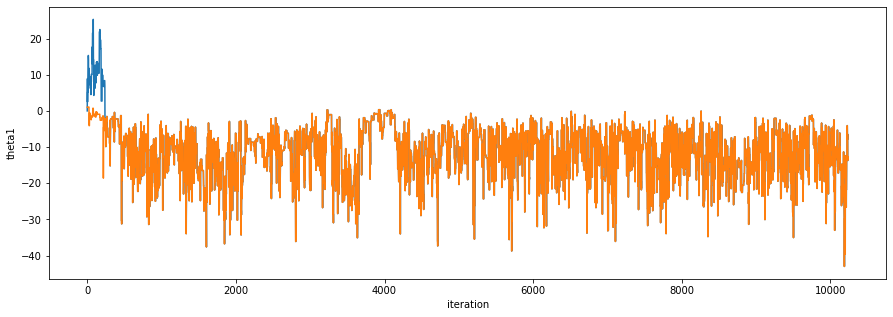

In [82]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta1', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta1', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

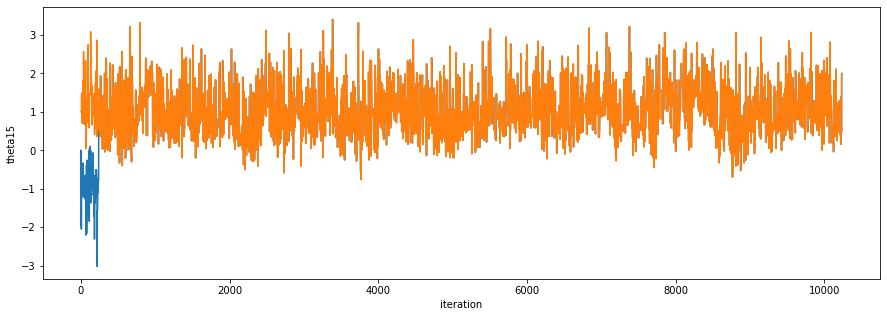

In [83]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta15', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta15', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

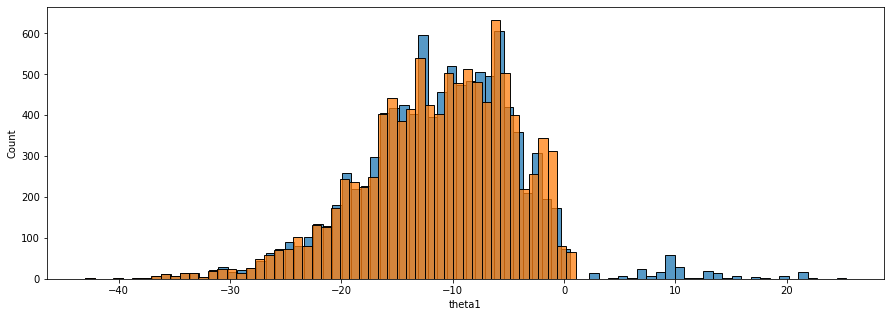

In [86]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.histplot(data = chain1_df, x = 'theta1', ax = ax)
sns.histplot(data = chain2_df, x = 'theta1', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

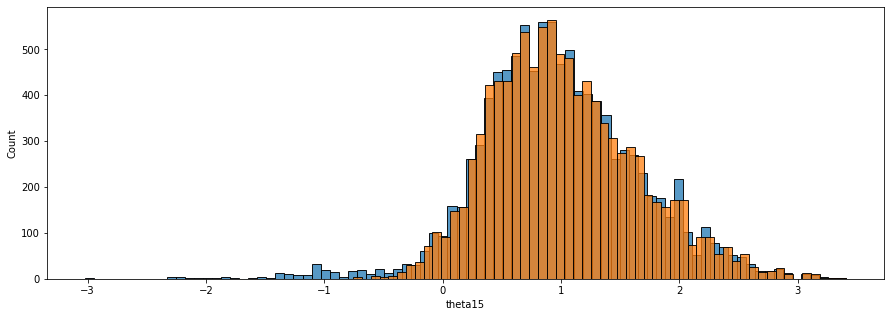

In [87]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.histplot(data = chain1_df, x = 'theta15', ax = ax)
sns.histplot(data = chain2_df, x = 'theta15', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

In [90]:
iteration_params = []

for i in range(100):

    lamb = tuning + 0.01
    
    params_x, params_y, iteration = coupled_metropolis2(data, x_init, y_init, equality, logp_irt1, tuning = np.exp(2 * c) * lamb, k = 1)
    iteration_params.append((params_x, params_y, iteration))


31
3
35
29
12
110
3
12
14
11
5
5
37
139
4
145
2
14
38
3
4
8
10
8
22
8
109
7
14
13
133
30
12
13
2
14
2
7
6
7
2
9
2
5
4
29
4
8
38
6
19
6
2
4
3
11
76
13
3
28
9
2
4
13
2
12
81
158
4
4
7
17
19
5
3
2
5
7
33
6
12
15
12
13
3
2
42
5
2
7
41
6
2
8
23
12
4
5
2
4


In [91]:
meeting_times = []
for _, _, meeting in iteration_params:
    meeting_times.append(meeting)


(array([76., 10.,  6.,  0.,  1.,  1.,  2.,  0.,  2.,  2.]),
 array([  2. ,  17.6,  33.2,  48.8,  64.4,  80. ,  95.6, 111.2, 126.8,
        142.4, 158. ]),
 <BarContainer object of 10 artists>)

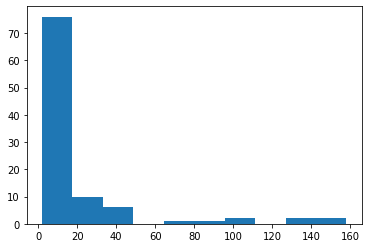

In [92]:
plt.hist(meeting_times)

In [93]:
np.mean(meeting_times)

19.66

# Gibbs

In [23]:
data = [Y]

a_1 = np.zeros(PROBLEM_COUNT)
b_1 = np.zeros(PROBLEM_COUNT)
theta_1 = np.zeros(STUDENT_COUNT)
w_1 = np.zeros((STUDENT_COUNT, PROBLEM_COUNT))
for p in range(len(w_1)):
    for i in range(len(w_1[p])):
        w_1[p][i] = random_polyagamma(z = a_1[i] * theta_1[p] + b_1[i])

a_2 = np.ones(PROBLEM_COUNT) * 100
b_2 = np.ones(PROBLEM_COUNT) * 100
theta_2 = np.ones(STUDENT_COUNT) * 40
w_2 = np.zeros((STUDENT_COUNT, PROBLEM_COUNT))
for p in range(len(w_2)):
    for i in range(len(w_2[p])):
        w_2[p][i] = random_polyagamma(z = a_2[i] * theta_2[p] + b_2[i])


x_init = np.array([w_1, a_1, b_1, theta_1], dtype = 'object')
y_init = np.array([w_2, a_2, b_2, theta_2], dtype = 'object')

params_x, params_y = gibbs_wrapper(data, x_init, y_init, max_iteration = 10000)


In [24]:
chain1_df = pd.DataFrame([np.hstack(x[1:]) for x in params_x], columns = [str(i) for i in range(110)])
chain2_df = pd.DataFrame([np.hstack(y[1:]) for y in params_y], columns = [str(i) for i in range(110)])
chain1_df = chain1_df.reset_index().rename(columns = {'index': 'iteration'})
chain2_df = chain2_df.reset_index().rename(columns = {'index': 'iteration'})

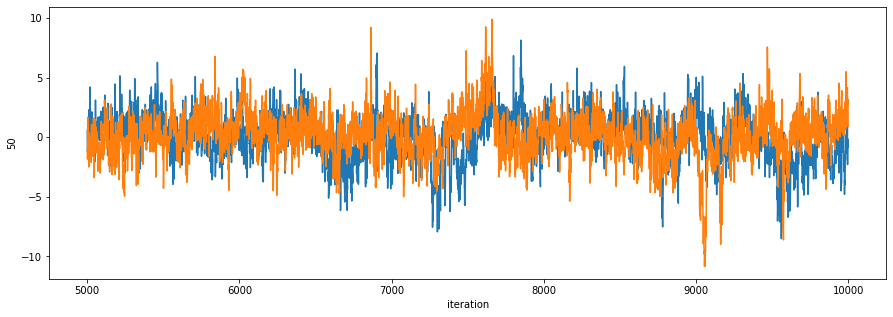

In [25]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df[5000:], x = 'iteration', y = '50', ax = ax)
sns.lineplot(data = chain2_df[5000:], x = 'iteration', y = '50', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

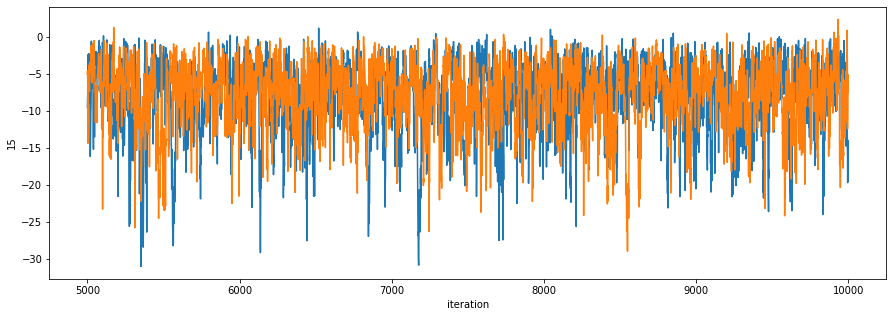

In [26]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df[5000:], x = 'iteration', y = '15', ax = ax)
sns.lineplot(data = chain2_df[5000:], x = 'iteration', y = '15', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

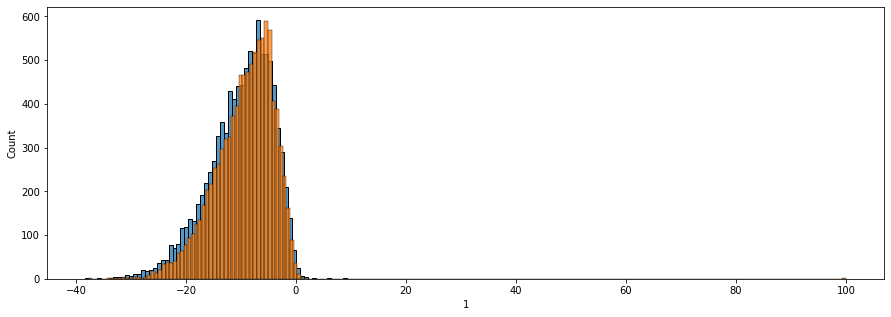

In [27]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.histplot(data = chain1_df, x = '1', ax = ax)
sns.histplot(data = chain2_df, x = '1', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.histplot(data = chain1_df, x = 'theta15', ax = ax)
sns.histplot(data = chain2_df, x = 'theta15', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()